<a id="top"></a>
# Beginner: Searching MAST using astroquery.mast

## Introduction and Goals:
This is a beginner tutorial on accessing the [MAST Archive](https://archive.stsci.edu) using the [Astroquery API](https://astroquery.readthedocs.io/en/latest/mast/mast.html). We'll cover the major search features you might find useful when querying for observations. By the end of this tutorial, you will:

* Understand how to search for observations hosted on the MAST Archive
* Download data products corresponding to your observations of interest
* Create a visual display of the downloaded data

## Table of Contents

* [Imports](#Imports)


* [Three ways to search for MAST observations](#Three-Ways-to-Search-for-MAST-Observations)
    - [By Region](#1.-By-Region)
    - [By Object Name](#2.-By-Object-Name)
    - [By Criteria](#crit)
    
    
* [Getting Associated Data Products](#Getting-Associated-Data-Products)
    - [Performing a Product Query](#Performing-a-Product-Query)
    - [Filtering Data Products](#Filtering-the-Data-Products)
    
    
* [Downloading Products](#Downloading-Products)
* [Displaying Data](#Displaying-Data)
* [Further Reading](#Further-Reading)

## Imports

Let's start by importing the packages we need for this notebook.

* `astroquery.mast` to access the MAST API
* `astropy` to create [coordinate objects](https://docs.astropy.org/en/stable/coordinates/index.html) and access the data
* `matplotlib` to plot the data

In [1]:
from astropy.coordinates import SkyCoord
from astroquery.mast import Observations
from astropy.io import fits
from matplotlib.colors import SymLogNorm

import matplotlib.pyplot as plt

%matplotlib inline

## Three Ways to Search for MAST Observations

### 1. By Region
To search by coordinates (and a radius), you can use `query_region`.

The coordinates can be given as a string or `astropy.coordinates` object, and the radius as a string or float object. If no radius is specified, the default is 0.2 degrees.

Let's try an example search with the coordinates (322.49324, 12.16683) and no radius.

In [2]:
# This will give a warning that the coordinates are being interpreted as an ICRS coordinate provided in degrees
obsByRegion = Observations.query_region("322.49324 12.16683")
len(obsByRegion)

3043

Excellent! At the time of writing, this search returns 2240 results. As the MAST archive grows, this number increases; you might see a larger value. Let's take a look a subset of the results.

In [3]:
# Preview the first 3 results
obsByRegion[:3].show_in_notebook()

The columns of the above table (there are many!) correspond to searchable fields in the MAST database. You can find the full list of criteria [here](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html) and an example of performing a search by criteria [down below](#crit).

If we want to avoid that pesky warning from the search above we can create a `coordinates` object and pass it to our search. Let's try that now, and in addition, let's add a radius of 1 arcsecond to this search.

In [4]:
# Set up our coordinates object
coord = SkyCoord(290.213503, -11.800746, unit='deg')

# Same search as above, now with a radius of 1 arcsecond
obsByRegion2 = Observations.query_region(coord, radius='1s')
len(obsByRegion2)

9

Sanity check: we expect that as the radius gets smaller, we get fewer results. In this case, only 15 results are returned.

Let's take a look at the results again, but let's limit the columns that get displayed.

In [5]:
# Let's limit the number of columns we see at once
columns = ['obs_collection', 'intentType', 'instrument_name', 
            'target_name', 't_exptime', 'filters', 'dataproduct_type']

# Show the results with the above columns only
obsByRegion2[columns].show_in_notebook()

This "streamlined" view is helpful: it avoids visual clutter and helps you to focus on the fields that are most relevant to your search.

### 2. By Object Name

To search for an object by name, you can use the `query.object` function. This function also optionally allows you to specify a radius.

The object name is first resolved to coordinates by a call to the [Simbad](https://simbad.unistra.fr/simbad/) and [NED](https://ned.ipac.caltech.edu/Documents/Overview) archives. Then, the search proceeeds based on these coordinates.

In [6]:
obsByName = Observations.query_object("M51",radius=".005 deg")

In [7]:
print("Number of results:",len(obsByName))

# Here we just print the values, but you can use '.show_in_table' like we did in the previous cell
print(obsByName[:10])

Number of results: 1745
intentType obs_collection provenance_name ... srcDen  obsid   distance
---------- -------------- --------------- ... ------ -------- --------
   science           TESS            SPOC ...    nan 27545566      0.0
   science           TESS            SPOC ...    nan 27347170      0.0
   science           TESS            SPOC ...    nan 27386992      0.0
   science           TESS            SPOC ...    nan 83163378      0.0
   science          SWIFT              -- ...    nan  1628611      0.0
   science          SWIFT              -- ... 5885.0  1491575      0.0
   science          SWIFT              -- ... 5885.0  1491576      0.0
   science          SWIFT              -- ... 5885.0  1493598      0.0
   science          SWIFT              -- ... 5885.0  1493597      0.0
   science          SWIFT              -- ... 5885.0  1493982      0.0


For some special catalogs, like those used with Kepler, K2, and TESS, astroquery performs a direct lookup using the MAST catalog. It is important to include both the **_catalog identifier_** and number when searching one of these datasets; for example, to query the TESS Input catalog you would use "TIC 261136679", rather than a plain
"261136679".

In [8]:
obsByTessName = Observations.query_object("TIC 261136679", radius="1s")

In [9]:
# As before, we use columns to limit the display
columns = ['obs_collection', 'wavelength_region', 'provenance_name', 't_min', 't_max', 'obsid']
obsByTessName[columns].show_in_notebook(display_length=10)

It's worth noting that even though we queried using the TESS Input Catalog, not all of the results are from the TESS mission. The TIC is a catalog like any other, and the MAST Archive resolves the input name to a location on the sky. Other missions that have observed the same region will also return results.

To search for results that are specific to TESS, or your mission of choice, see the 'by other criteria' section below.

### 3. By Other Criteria (with or without name/region) <a id="crit"></a>

To search for observations based on additonal parameters, you can use `query_criteria`. In a sense, this is a more powerful version of the tools above, as you can still search by coordinates and objectname; however, you can inculde additional desired criteria. You may also run the search without specifying a name or coordinates.

To perform the search, give your critera as keyword arguments. Valid criteria and their descriptions are listed [here](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html). (Note that these are columns of the results tables we saw above!) Some relevant examples are: "filters", "t_exptime" (exposure time), instrument_name, "provenance_name", and "sequence_number". 

Let's for TESS Sector 9 data with an exposure time between 1400 and 1500s.

In [10]:
obsByCriteria = Observations.query_criteria(obs_collection=["TESS"], sequence_number=9,
                                            t_exptime=[1400,1500])

In [11]:
columns = ['target_name','s_ra', 's_dec', 't_exptime', 'obsid']
obsByCriteria[columns].show_in_notebook(display_length=5)

There's no limit on the number of filters you can apply in a search. It may be an interesting exercise for the reader to go through the example below and figure out what exactly we're searching for.

(Hint: check the [field descriptions](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html))

In [12]:
# Make sure to run this cell, as the data is used in the sections that follow

exByCriteria = Observations.query_criteria(obs_collection=["HLA"], s_dec=[50,60], 
                                            calib_level=[3], proposal_pi="Mould*", 
                                            dataproduct_type="IMAGE", t_max=[49800,49820])

In [13]:
columns = ['obs_collection', 'obs_id', 'target_name', 'filters', 'instrument_name', 'proposal_id']
exByCriteria[columns].show_in_notebook()

## Getting Associated Data Products

### Performing a Product Query


Each observation returned from a MAST query can have one or more associated data products. For example, a JWST observation might return an [uncalibrated file](https://outerspace.stsci.edu/display/MASTDOCS/Supplemental+Products), [a guide-star file](https://jwst-docs.stsci.edu/jwst-observatory-characteristics/jwst-guide-stars), and the science data you're searching for.

You can input a table of observations or list of observation ids (“obs_id”) and `get_product_list` will return a table containing the associated data products.

Since we already have a list of observations, we can use that as the starting point for our query. To keep it simple, let's look at only the last observation from our search above.

In [14]:
# Let's select a small subset from our critera search above
newObsList = exByCriteria[-1:]

# Now we get the list of products associated with that observation
dataProducts = Observations.get_product_list(newObsList)

In [15]:
dataProducts.show_in_notebook(display_length=5)

### Filtering the Data Products

After the data products have been retrieved, you can use `filter_products` to download only data products that meet your given criteria. Available filters are listed [here](https://mast.stsci.edu/api/v0/_productsfields.html). Some examples are: “mrp_only” (Minimum Recommended Products) and “extension” (file extension).

A note on filtering: each listed filter is joined with an AND, but each option within that filter is joined with an OR. For example, the search below will return any products that are 'science' type **and** have a calibration level of 2 **or** 3.

In [16]:
scienceProducts = Observations.filter_products(dataProducts, productType=["SCIENCE"],
                                               calib_level=[2,3], mrp_only=False)

In [17]:
scienceProducts.show_in_notebook(display_length=5)

## Downloading Products
Passing a table of products (like the one above) to `download_products` will download the entire table. You can also pass a list of Observation IDs (obs_id) if you know them.

`download_products` also allows you to filter data as you request the download. In the example below, we will only download the drizzled files (drz.fits).

Products will by default be downloaded into the current working directory, in a subdirectory called "mastDownload."<br>
The full local file paths will have the form "mastDownload/Mission/Observation ID/file."

In [18]:
# This is the filtered download of the scienceProducts table
manifest = Observations.download_products(scienceProducts, extension=("drz.fits"))

# Uncomment below for "plain" download of the scienceProducts table
# manifest = Observations.download_products(scienceProducts)

 [Done]


 [Done]


Note: `download_products` includes caching by default. If you have downloaded the files before, they will not be downloaded again unless caching is turned off. This may cause issues if the data is updated and the filename remains the same!

In [19]:
manifest.show_in_notebook()

The manifest returns useful information about the status of the files. You can find the local path, along with a status. This will either be COMPLETE, SKIPPED, or ERROR. If the status is ERROR, there will be additional information in the 'Message' column. The URL field includes a link to directly download the data.

## Displaying Data

At this point the data is ready for analysis, and we are done querying the MAST Archive.

Below we take a look at the data files using `astropy.fits` and `matplotlib`.

In [20]:
# Get the filenames from the manifest
filename0 = manifest['Local Path'][0]
filename1 = manifest['Local Path'][1]

# Open the files using astropy.fits
file1 = fits.open(filename0)
file2 = fits.open(filename1)

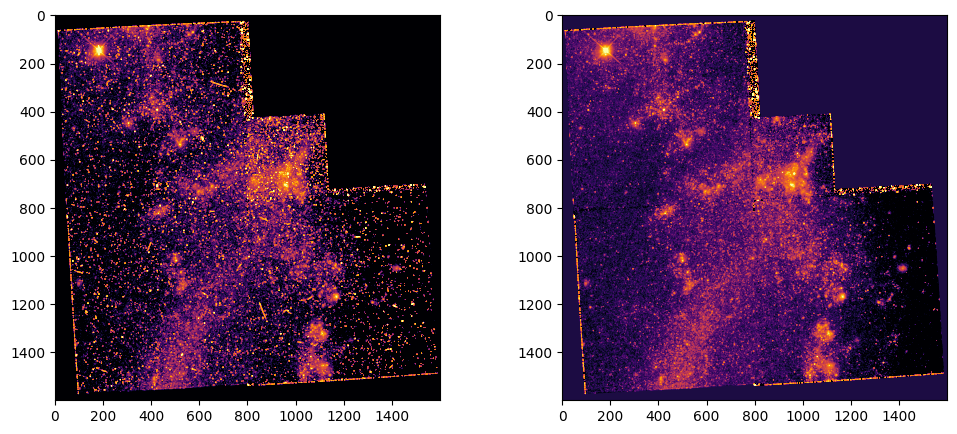

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(5)
f.set_figwidth(12)
ax1.imshow(file1[0].data, cmap="inferno", norm=SymLogNorm(linthresh=0.03,vmin=0, vmax=1.5))
ax2.imshow(file2['SCI'].data, cmap="inferno", norm=SymLogNorm(linthresh=0.03,vmin=-0.01, vmax=1.5))

We see the same region of the sky, with subtle differences caused by the differing filters.

## Further Reading
Full documentation on `astroquery.mast` can be found [here](https://astroquery.readthedocs.io/en/latest/mast/mast.html).

## About this Notebook
For additonal questions, comments, or feedback, please email `archive@stsci.edu`. 

**Authors:** Thomas Dutkiewicz, Scott Fleming <br>
**Keywords:** MAST, astroquery <br>
**Latest update** Oct 2022 <br>
**Next Review:** Apr 2023

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 